# Dependencies

In [1]:
!pip install tensorflow==1.15

In [2]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


# GAN

In [3]:
class GAN():
  def __init__(self):
    self.img_rows = 32
    self.img_cols = 32
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100
    optimizer = Adam(0.0002, 0.5) 
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    self.generator = self.build_generator()

    z = Input(shape=(self.latent_dim,))

    img , distance = self.generator(z)

    self.discriminator.trainable = False

    validity = self.discriminator(img)
    self.combined = Model(z, [validity, distance])
    self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=optimizer)
    
  def build_generator(self):
    #functional code
    input_layer = Input(shape=(self.latent_dim,))
    layer = Dense(256, activation=LeakyReLU(alpha=0.2))(input_layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(512, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)
    layer = Dense(1024, activation=LeakyReLU(alpha=0.2))(layer)
    layer = BatchNormalization(momentum=0.8)(layer)

    out1 = Dense(np.prod(self.img_shape), activation='tanh' )(layer)
    out1 = Reshape(self.img_shape)(out1)

    out2 =  Dense(1, activation='sigmoid' )(layer)

    noise = input_layer
    img = out1
    distance = out2

    model = Model(noise, [img,distance])
    model.summary()
    return model

        
  def build_discriminator(self):
    model = Sequential()
    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(img, validity)

  def train(self, epochs, batch_size, sample_interval):
    (X_train, _), (_, _) = cifar10.load_data()
    

    X_train = X_train / 127.5 - 1.
    #X_train = np.expand_dims(X_train, axis=3)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
        
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs, distances = self.generator.predict(noise)
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)

      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      real_data_discrimination = []
      for i in range(0,len(imgs)):
        real_data_discrimination.append(1/(np.linalg.norm(imgs[0]))) 
      real_data_discrimination = np.array(real_data_discrimination)

      g_loss = self.combined.train_on_batch(noise, [valid,real_data_discrimination])
      

      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G loss: %f loss]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
      if epoch % sample_interval == 0:
        self.sample_images(epoch)

  def sample_images(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs, distances = self.generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
      #fig.savefig("images/%d.png" % epoch)
      plt.close()

# Train

In [4]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=26000, batch_size=64, sample_interval=1000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,704,961
Trainable param

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          25856       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256)          1024        dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          131584      batch_normalization_1[0][0]      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.778256, acc.: 24.22%] [G loss: 1.533420, G loss: 0.644625 loss]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
21001 [D loss: 0.338378, acc.: 86.72%] [G loss: 3.718339, G loss: 3.563166 loss]
21002 [D loss: 0.410483, acc.: 82.81%] [G loss: 2.418247, G loss: 2.228588 loss]
21003 [D loss: 0.458716, acc.: 82.81%] [G loss: 3.516034, G loss: 3.305918 loss]
21004 [D loss: 0.414755, acc.: 81.25%] [G loss: 4.350805, G loss: 4.117993 loss]
21005 [D loss: 0.589242, acc.: 74.22%] [G loss: 2.489759, G loss: 2.320901 loss]
21006 [D loss: 0.535405, acc.: 72.66%] [G loss: 4.361680, G loss: 4.205887 loss]
21007 [D loss: 0.484773, acc.: 84.38%] [G loss: 4.953163, G loss: 4.787688 loss]
21008 [D loss: 0.676678, acc.: 74.22%] [G loss: 5.109991, G loss: 4.955758 loss]
21009 [D loss: 0.731046, acc.: 71.09%] [G loss: 5.226870, G loss: 5.086331 loss]
21010 [D loss: 0.906693, acc.: 61.72%] [G loss: 6.311792, G loss: 6.114755 loss]
21011 [D loss: 0.975037, acc.: 68.75%] [G loss: 8.156929, G loss: 7.972708 loss]
21012 [D loss: 0.619546, acc.: 80.47%] [G loss: 5.119083, 

# Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

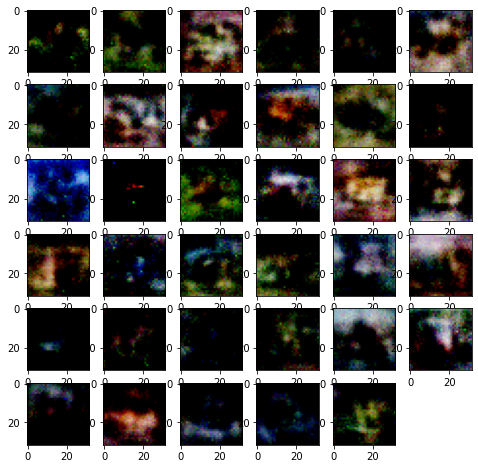

In [5]:
noise = np.random.normal(0, 1, (36,100))
gen_imgs,distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

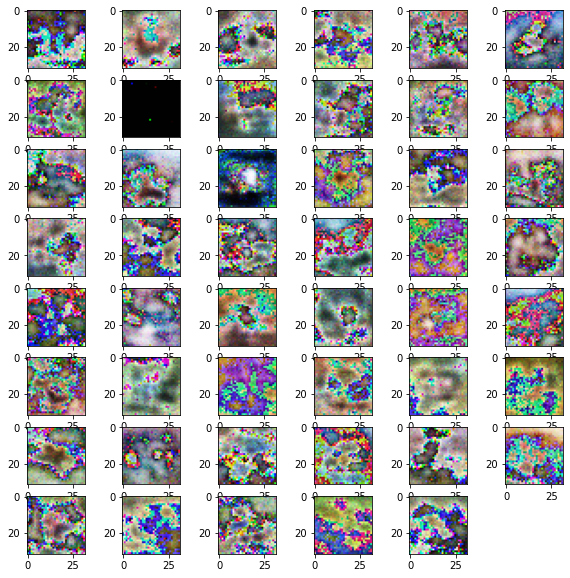

In [6]:
noise = np.random.normal(0, 1, (48,100))
gen_imgs , distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(10, 10))
columns = 6
rows = 8
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow((gen_imgs[i] * 255).astype(np.uint8))
plt.show()

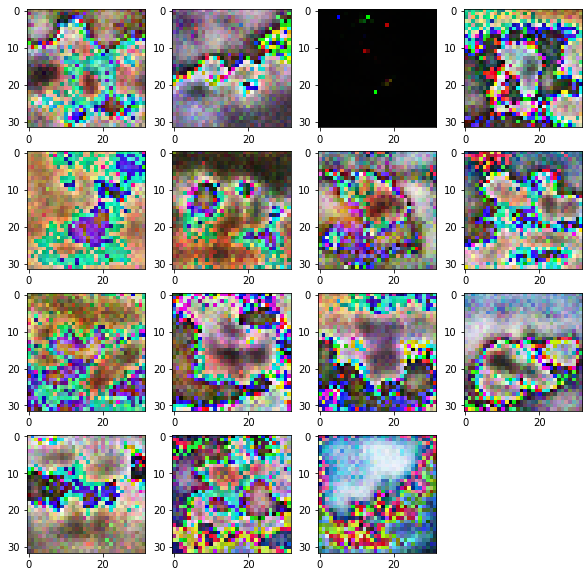

In [7]:
noise = np.random.normal(0, 1, (16,100))
gen_imgs , distance = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow((gen_imgs[i] * 255).astype(np.uint8))
plt.show()